In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
print(tf.__version__)
print(pd.__version__)

1.12.0
0.23.4


In [3]:
# set variables 
main_folder = 'input_data_celeb/celeba_dataset/'
images_folder = main_folder +'img_align_celeba/'

EXAMPLE_PIC = images_folder + '1.png'
#EXAMPLE_PIC = 'C://Users/karim/1.png'


TRAINING_SAMPLES = 660
VALIDATION_SAMPLES = 170
TEST_SAMPLES = 170
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 16
NUM_EPOCHS = 20

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv('attribute_list_mediumset.csv')
df_attr.set_index('file_name', inplace=True)
#df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(1000, 5)

In [5]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 hair_color
1 eyeglasses
2 smiling
3 young
4 human


smiling    1
young      1
human     -1
Name: 1.png, dtype: int64

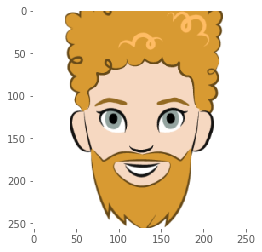

In [6]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['smiling','young','human']] #some attributes

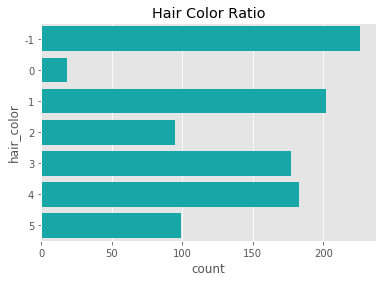

In [7]:
plt.title('Hair Color Ratio')
sns.countplot(y='hair_color', data=df_attr, color="c")

plt.show()

In [54]:
df_partition = pd.read_csv('list_eval_partition_mediumset.csv')
df_partition.head()

,file_name,partition
0,1.png,0
1,2.png,0
2,3.png,0
3,4.png,0
4,5.png,0


In [55]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    660
1    170
2    170
Name: partition, dtype: int64

In [56]:
# join the partition with the attributes
df_partition.set_index('file_name', inplace=True)
df_par_attr = df_partition.join(df_attr['hair_color'], how='inner')
#df_par_attr.tail(100)
df_par_attr['hair_color'].value_counts().sort_index()

-1    226
 0     18
 1    202
 2     95
 3    177
 4    183
 5     99
Name: hair_color, dtype: int64

In [26]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df_TRAIN(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    #BOLD PEOPLE
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(10))
    #BLOND HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(50))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 2)].sample(int(50))])
    #BROWN HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 3)].sample(int(50))])
    #BLACK HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 4)].sample(int(50))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 5)].sample(int(50))])
    
    print(df_)
    
    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],6)

    return x_, y_

In [46]:
def generate_df_VAL(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
   #BOLD PEOPLE
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(3))
    #BLOND HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 2)].sample(int(10))])
    #BROWN HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 3)].sample(int(10))])
    #BLACK HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 4)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 5)].sample(int(10))])

    x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
    x_ = x_.reshape(x_.shape[0], 256, 256, 3)
    y_ = np_utils.to_categorical(df_[attr],6)

    return x_, y_

In [44]:
def generate_df_TEST(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    #BOLD PEOPLE
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(3))
    #BLOND HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 2)].sample(int(10))])
    #BROWN HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 3)].sample(int(10))])
    #BLACK HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 4)].sample(int(10))])
    #GINGER HAIR PEOPLE
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 5)].sample(int(10))])

    x_ = []
    y_ = []

    for index, target in df_.iterrows():
        im = cv2.imread(images_folder + index)
        im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
        im = np.expand_dims(im, axis =0)
        x_.append(im)
        y_.append(target[attr])

    return x_, y_

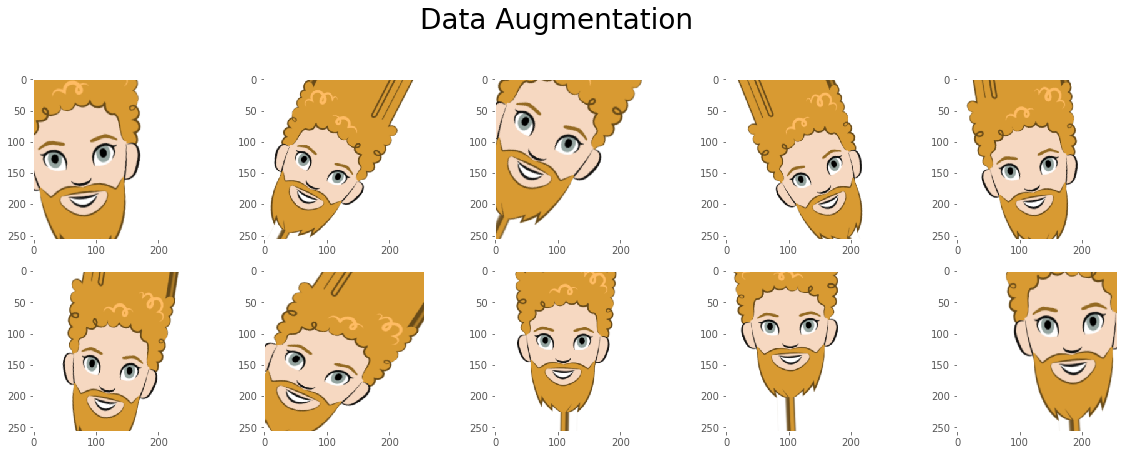

In [39]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(256, 256, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

In [28]:
# Train data
x_train, y_train = generate_df_TRAIN(0, 'hair_color', TRAINING_SAMPLES)

print(x_train)
print(y_train)

# Train - Data Preparation - Data Augmentation with generators
train_datagen =  ImageDataGenerator(
  preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
)

train_datagen.fit(x_train)

train_generator = train_datagen.flow(
x_train, y_train,
batch_size=BATCH_SIZE,
)

           partition  hair_color
file_name                       
291.png            0           0
240.png            0           0
506.png            0           0
280.png            0           0
136.png            0           0
366.png            0           0
563.png            0           0
80.png             0           0
225.png            0           0
53.png             0           0
274.png            0           1
647.png            0           1
69.png             0           1
30.png             0           1
550.png            0           1
439.png            0           1
166.png            0           1
401.png            0           1
406.png            0           1
55.png             0           1
37.png             0           1
540.png            0           1
216.png            0           1
488.png            0           1
314.png            0           1
526.png            0           1
300.png            0           1
156.png            0           1
9.png     

In [30]:
# def flattener(tr_X):
#     x_new=[]
#     for i in tr_X:
#         x_new.append(i.flatten())
#     x_new=np.array(x_new)
#     return x_new
# new_y = flattener(y_train)
# print(new_y)

In [47]:
# Validation Data
x_valid, y_valid = generate_df_VAL(1, 'hair_color', VALIDATION_SAMPLES)


'\n# Validation - Data Preparation - Data Augmentation with generators\nvalid_datagen = ImageDataGenerator(\n  preprocessing_function=preprocess_input,\n)\n\nvalid_datagen.fit(x_valid)\n\nvalidation_generator = valid_datagen.flow(\nx_valid, y_valid,\n)\n'

In [48]:
# Import InceptionV3 Model
inc_model = InceptionV3(weights='inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("number of layers:", len(inc_model.layers))
#inc_model.summary()

number of layers: 311


In [49]:
#Adding custom Layers
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)

#CHOOSE 6 OUTPUTS AS WE HAVE 6 DIFFERENT CLASS ATTRIBUTES
predictions = Dense(6, activation="softmax")(x)

In [50]:
# creating the final model 
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Lock initial layers to do not be trained
for layer in model_.layers[:52]:
    layer.trainable = False

# compile the model
model_.compile(optimizer=SGD(lr=0.0001, momentum=0.9)
                    , loss='categorical_crossentropy'
                    , metrics=['accuracy'])

In [52]:
#https://keras.io/models/sequential/ fit generator
checkpointer = ModelCheckpoint(filepath='weights.best.inc.multiclass1.hdf5', 
                               verbose=1, save_best_only=True)

In [53]:
hist = model_.fit_generator(train_generator
                     , validation_data = (x_valid, y_valid)
                      , steps_per_epoch= TRAINING_SAMPLES/BATCH_SIZE
                      , epochs= NUM_EPOCHS
                      , callbacks=[checkpointer]
                      , verbose=1
                    )

Epoch 1/20
42/41 [==============================] - 312s 7s/step - loss: 1.8560 - acc: 0.1652 - val_loss: 1.7477 - val_acc: 0.2264

Epoch 00001: val_loss improved from inf to 1.74773, saving model to weights.best.inc.multiclass1.hdf5
Epoch 2/20
42/41 [==============================] - 305s 7s/step - loss: 1.7279 - acc: 0.2232 - val_loss: 1.7048 - val_acc: 0.3019

Epoch 00002: val_loss improved from 1.74773 to 1.70481, saving model to weights.best.inc.multiclass1.hdf5
Epoch 3/20
42/41 [==============================] - 297s 7s/step - loss: 1.7059 - acc: 0.2413 - val_loss: 1.6849 - val_acc: 0.3962

Epoch 00003: val_loss improved from 1.70481 to 1.68493, saving model to weights.best.inc.multiclass1.hdf5
Epoch 4/20
42/41 [==============================] - 302s 7s/step - loss: 1.6145 - acc: 0.3333 - val_loss: 1.6680 - val_acc: 0.3962

Epoch 00004: val_loss improved from 1.68493 to 1.66803, saving model to weights.best.inc.multiclass1.hdf5
Epoch 5/20
42/41 [==============================] - 

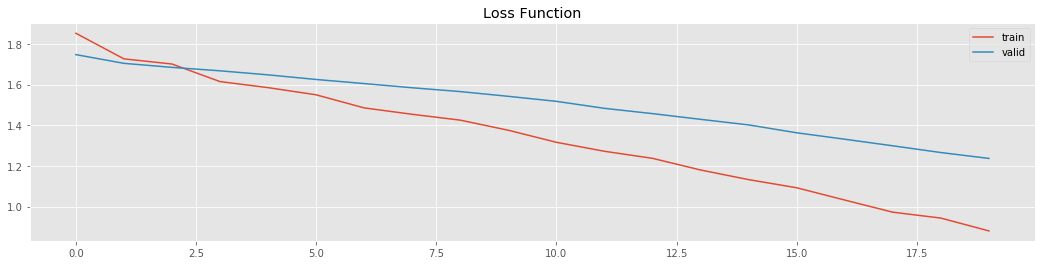

In [57]:
# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['loss'], label = 'train')
plt.plot(hist.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

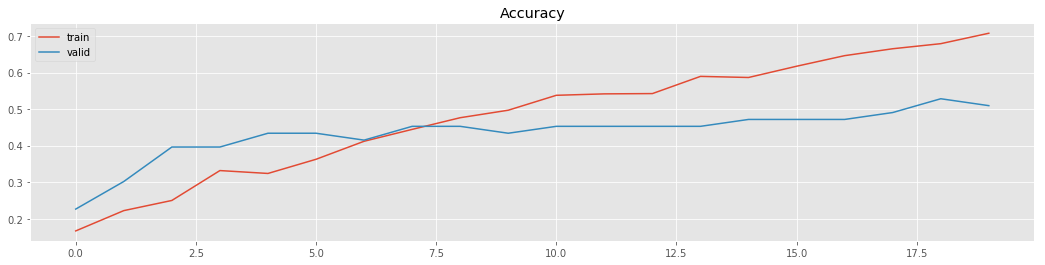

In [58]:
# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(hist.history['acc'], label = 'train')
plt.plot(hist.history['val_acc'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()

In [59]:
#load the best model
model_.load_weights('weights.best.inc.multiclass1.hdf5')

In [62]:
# Test Data
x_test, y_test = generate_df_TEST(2, 'hair_color', TEST_SAMPLES)

# generate prediction
model_predictions = [np.argmax(model_.predict(feature)) for feature in x_test ]

print(model_predictions)

# report test accuracy
test_accuracy = 100 * np.sum(np.array(model_predictions)==y_test) / len(model_predictions)
print('Model Evaluation')
print('Test accuracy: %.4f%%' % test_accuracy)
print('f1_score:', f1_score(y_test, model_predictions, average=None))

[5, 1, 1, 1, 1, 5, 2, 1, 1, 3, 2, 2, 2, 1, 2, 2, 1, 2, 5, 2, 2, 2, 2, 3, 3, 1, 5, 5, 2, 2, 2, 2, 4, 3, 5, 4, 3, 4, 3, 4, 4, 4, 3, 5, 5, 5, 5, 1, 5, 5, 5, 5, 2]
Model Evaluation
Test accuracy: 49.0566%
f1_score: [0.         0.4        0.53846154 0.23529412 0.625      0.66666667]


In [102]:
#dictionary to name the prediction
attribute_target = {0: 'Bald'
                , 1: 'Blond'
                , 2: 'Ginger Hair'
                , 3: 'Brown Hair'
                , 4: 'Black Hair'
                , 5: 'Gray Hair'
                , -1: 'Noise'}

def img_to_display(filename):
    # inspired on this kernel:
    # https://www.kaggle.com/stassl/displaying-inline-images-in-pandas-dataframe
    
    i = Image.open(filename)
    i.thumbnail((200, 200), Image.LANCZOS)
    
    with BytesIO() as buffer:
        i.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()
    

def display_result(filename, prediction, target):
    '''
    Display the results in HTML
    
    '''

    attribute = 'FIRST'
    attribute_icon = "https://i.imgur.com/nxWan2u.png"
    
    #print(prediction[1])
    print(prediction)
    highest_prediction = max(prediction)
    print(highest_prediction)
    
    
    if prediction[0] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Bald'
        
    if prediction[1] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Blond'
        
    if prediction[2] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Ginger Hair'
    if prediction[3] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Brown Hair'
    if prediction[4] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Black Hair'
    if prediction[5] == highest_prediction:
        attribute_icon = "https://i.imgur.com/oAAb8rd.png"
        attribute = 'Gray Hair'
    
    display_html = '''
    <div style="overflow: auto;  border: 2px solid #D8D8D8;
        padding: 5px; width: 420px;" >
        <img src="data:image/jpeg;base64,{}" style="float: left;" width="200" height="200">
        <div style="padding: 10px 0px 0px 20px; overflow: auto;">
            <img src="{}" style="float: left;" width="40" height="40">
            <h3 style="margin-left: 50px; margin-top: 2px;">{}</h3>
            <p style="margin-left: 50px; margin-top: 5px; font-size: 12px">{} prob.</p>
            <p style="margin-left: 50px; margin-top: 10px; font-size: 10px">Real Target: {}</p>
            <p style="margin-left: 50px; margin-top: 25px; font-size: 10px">Filename: {}</p>
        </div>
    </div>
    '''.format(img_to_display(filename)
               , attribute_icon
               , attribute
               , "{0:.2f}%".format(round(max(prediction)*100,2))
               , attribute_target[target]
               , filename.split('/')[-1]
               )

    display(HTML(display_html))

In [103]:
def attribute_prediction(filename):
    
    im = cv2.imread(filename)
    im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (256, 256)).astype(np.float32) / 255.0
    im = np.expand_dims(im, axis =0)
    
    # prediction
    result = model_.predict(im)
    prediction = np.argmax(result)
    
    return result
    

[0.04310997 0.17415576 0.32046178 0.2956712  0.06474395 0.10185733]
0.32046178



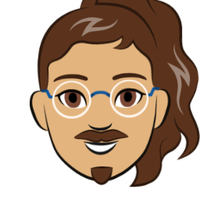

[0.07697153 0.21502483 0.13791189 0.2308835  0.18167599 0.1575323 ]
0.2308835



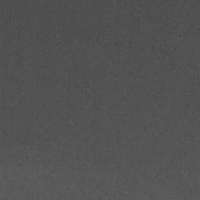

[0.0202579  0.21160805 0.53403306 0.10842369 0.01913542 0.10654185]
0.53403306



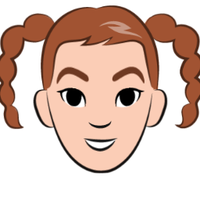

[0.06224965 0.13395414 0.18951336 0.31004086 0.14844294 0.15579914]
0.31004086



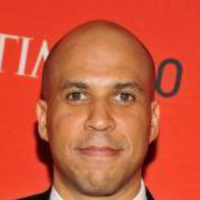

[0.03358591 0.14987794 0.07661514 0.35868683 0.27352625 0.107708  ]
0.35868683



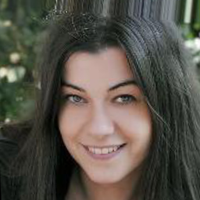

[0.02418095 0.06178057 0.05785426 0.24543172 0.55335677 0.05739569]
0.55335677



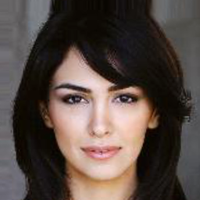

[0.02007649 0.3268665  0.15201214 0.14204252 0.05511814 0.30388418]
0.3268665



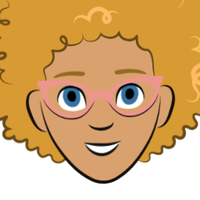

[0.05646542 0.32465112 0.18177317 0.19198512 0.13787821 0.107247  ]
0.32465112



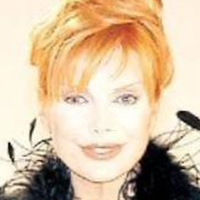

[0.04086841 0.27304262 0.24144426 0.10861225 0.08799132 0.24804118]
0.27304262



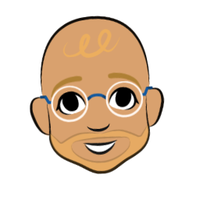

[0.02208376 0.28461027 0.11641645 0.13095032 0.03994147 0.4059978 ]
0.4059978



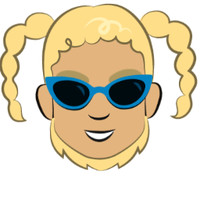

[0.03846582 0.171408   0.49812979 0.14591968 0.03766952 0.10840719]
0.49812979



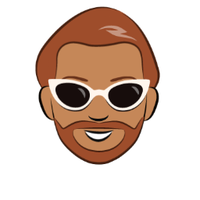

[0.01546624 0.05523641 0.03197873 0.20964447 0.6133337  0.07434046]
0.6133337



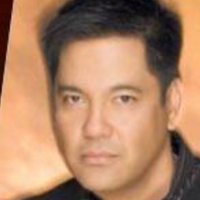

[0.03811208 0.09787413 0.12675954 0.3060023  0.3552589  0.07599308]
0.3552589



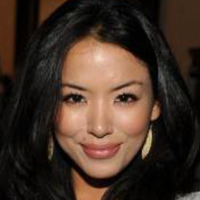

[0.03475267 0.19966143 0.11435529 0.19716614 0.09916966 0.35489485]
0.35489485



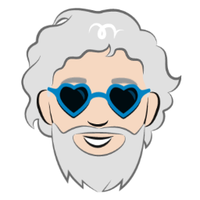

[0.01016119 0.03480266 0.03467874 0.2133439  0.6851502  0.02186327]
0.6851502



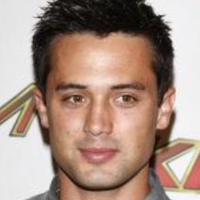

[0.02013076 0.14663336 0.26234674 0.2939554  0.19036642 0.08656736]
0.2939554



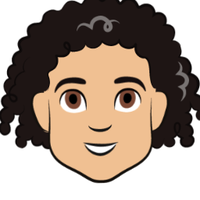

[0.01544033 0.16510282 0.06426413 0.13136232 0.04632674 0.5775037 ]
0.5775037



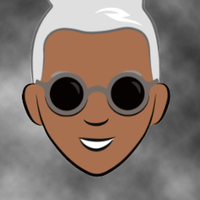

[0.00552065 0.01713337 0.02675299 0.23813735 0.68091094 0.03154464]
0.68091094



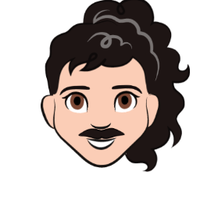

[0.01786791 0.06686012 0.16345298 0.4620886  0.22701842 0.06271194]
0.4620886



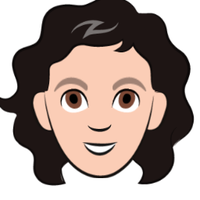

[0.09484412 0.25040174 0.11431193 0.19773035 0.13124692 0.21146497]
0.25040174



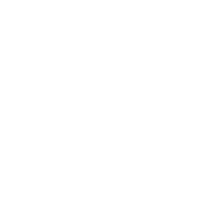

In [105]:
#select random images of the test partition
df_to_test = df_par_attr[(df_par_attr['partition'] == 2)].sample(20)

for index, target in df_to_test.iterrows():
    result = attribute_prediction(images_folder + index)
    #print(result)
    #display result
    display_result(images_folder + index, result[0], target['hair_color'])